In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import face3d
import vxl
import sys
sys.path.append('/proj/pix2face/pix2face_net')
sys.path.append('/proj/pix2face/python/')
import pix2face
from PIL import Image


import pix2face_estimation.coefficient_estimation
import pix2face_estimation.mesh_renderer
import pix2face_estimation.geometry_utils as geometry_utils

### Estimate PNCC and Offsets using pix2face network

In [2]:
cuda_device = None


In [3]:
model = pix2face.test.load_pretrained_model(cuda_device=None)

loading /proj/pix2face/pix2face_net/data/models/pix2face_unet_v10_pytorch0.4_cpu.pt ...
...done.


In [4]:
img_fname = '/proj/pix2face/pix2face_net/data/CASIA_0000107_004.jpg' 
img = np.array(Image.open(img_fname))
outputs = pix2face.test.test(model, [img,])
pncc = outputs[0][0]
offsets = outputs[0][1]

In [5]:
pncc_rgb = pncc / 300.0 + 0.5
offsets_rgb = offsets / 60.0 + 0.5

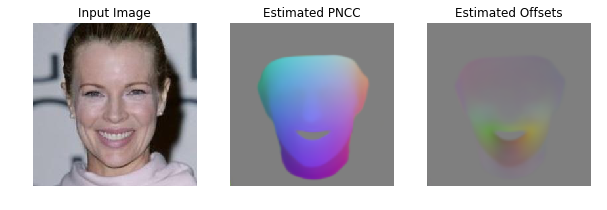

In [6]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(pncc_rgb)
ax[1].set_title('Estimated PNCC')
ax[2].imshow(offsets_rgb)
ax[2].set_title('Estimated Offsets')
for a in ax:
    a.axis('off')

In [7]:
pix2face_data = pix2face_estimation.coefficient_estimation.load_pix2face_data()

### Estimate Coefficients from PNCC and Offsets

In [8]:
# estimate coefficients
img_ids = ['img0',]
coeffs = pix2face_estimation.coefficient_estimation.estimate_coefficients(img, model, pix2face_data, cuda_device)

In [9]:
render = pix2face_estimation.coefficient_estimation.render_coefficients(coeffs, pix2face_data)

In [10]:
surrey_model_fp = '/proj/pix2face/face3d/external/eos/share/sfm_shape_3448.bin'
surrey_model_blendshapes = '/proj/pix2face/face3d/external/eos/share/expression_blendshapes_3448.bin'
mesh_fp = '/proj/pix2face/face3d/data_3DMM/'
matrix_fp ='/proj/pix2face/scripts/basel_to_surrey_rigid_transform.txt'
head_mesh = face3d.head_mesh(mesh_fp)
debug_dir = '/tmp'
estimator_eos = face3d.media_coefficient_from_PNCC_and_offset_estimator_eos(head_mesh, surrey_model_fp, surrey_model_blendshapes, True, debug_dir)
[coeffs_eos, retval_eos] = estimator_eos.estimate_coefficients_perspective(img_ids, [pncc], [offsets], img_fname, matrix_fp)
render_eos = pix2face_estimation.coefficient_estimation.render_coefficients(coeffs_eos, pix2face_data)

In [11]:
coeffs_eos.expression_coeffs(0)

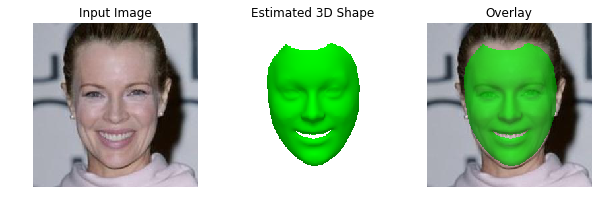

In [12]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(render)
ax[1].set_title('Estimated 3D Shape')
mask = render[:,:,3] > 0
blended = np.array(img)
img_weight = 0.3
blended[mask] = blended[mask]*img_weight + render[mask,0:3]*(1.0 - img_weight)
ax[2].imshow(blended)
ax[2].set_title('Overlay')
for a in ax:
    a.axis('off')

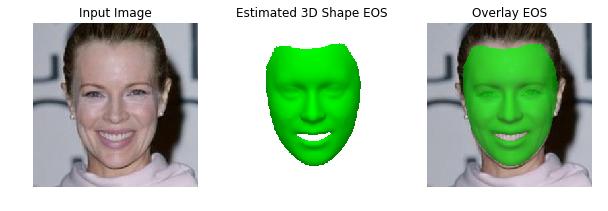

In [13]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(render_eos)
ax[1].set_title('Estimated 3D Shape EOS')
mask = render_eos[:,:,3] > 0
blended_eos = np.array(img)
img_weight = 0.3
blended_eos[mask] = blended_eos[mask]*img_weight + render_eos[mask,0:3]*(1.0 - img_weight)
ax[2].imshow(blended_eos)
ax[2].set_title('Overlay EOS')
for a in ax:
    a.axis('off')

### Render 3D-Jittered Images

In [14]:
renderer = pix2face_estimation.mesh_renderer.get_mesh_renderer()
jitterer = face3d.media_jitterer_perspective([img,], coeffs_eos, pix2face_data.head_mesh, pix2face_data.subject_components, pix2face_data.expression_components, renderer, "")


In [15]:
new_expression_coeffs = np.zeros_like(coeffs.expression_coeffs(0))
# manually alter expression
new_expression_coeffs[0] = 1.0 #anger
new_expression_coeffs[1] = 0.0 #disgust
new_expression_coeffs[2] = 0.0 # fear
new_expression_coeffs[3] = 0.0 # happiness
new_expression_coeffs[4] = 0.0 # sadness
new_expression_coeffs[5] = 0.0 #surprise
render_neutral = jitterer.render(coeffs_eos.camera(0), coeffs_eos.subject_coeffs(), new_expression_coeffs, pix2face_data.subject_components, pix2face_data.expression_components)


In [16]:
# manually alter pose
delta_R = vxl.vgl.rotation_3d(geometry_utils.Euler_angles_to_quaternion(-np.pi/6, 0, 0, order='YXZ'))
cam = coeffs.camera(0)
new_R = cam.rotation * delta_R
new_cam = face3d.perspective_camera_parameters(cam.focal_len, cam.principal_point, new_R, cam.translation, cam.nx, cam.ny)
render_rot = jitterer.render(new_cam, coeffs_eos.subject_coeffs(), coeffs_eos.expression_coeffs(0), pix2face_data.subject_components, pix2face_data.expression_components)

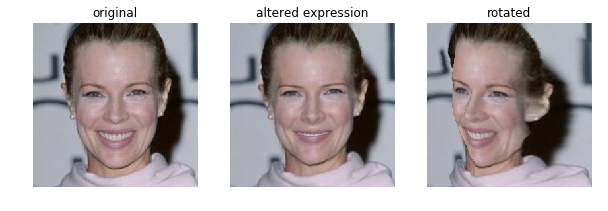

In [17]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('original')
ax[1].imshow(render_neutral[:,:,0:3])
ax[1].set_title('altered expression')
ax[2].imshow(render_rot[:,:,0:3])
ax[2].set_title('rotated')
for a in ax:
    a.axis('off')